In [10]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
%config InlineBackend.figure_format = 'svg'

In [1]:
cd /Users/fred/Umila/numila

/Users/fred/Umila/numila


In [2]:
from sklearn import metrics
import pandas as pd
import itertools
import matplotlib.pyplot as plt
import seaborn
seaborn.set_style('whitegrid')
seaborn.set_palette('muted')

from main import run


# ROC

In [3]:
roc_df = pd.read_pickle('pickles/roc')

In [4]:
def roc_plot(df):
    ax = plt.subplot(1,1,1)
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')

    for i, row in df.iterrows():
        plt.plot(row.fpr, row.tpr, label='{0} (area = {1:0.2f})'
                 .format(row.model, row['auc']))

    # Sort labels in legend.
    handles, labels = ax.get_legend_handles_labels()
    def get_aoc(handle_label):
        label = handle_label[1]
        return float(label[-5:-1])
    hl = sorted(zip(handles, labels), key=get_aoc, reverse=True)
    handles2, labels2 = zip(*hl)
    ax.legend(handles2, labels2, loc=4, frameon=True)

    plt.gca().set_aspect('equal', adjustable='box')
    plt.gcf().set_size_inches(4, 4)

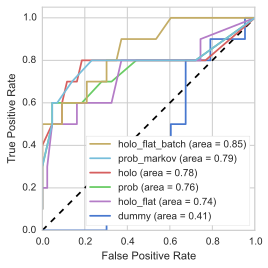

In [11]:
# Plot roc curve for English.
roc_plot(roc_df.query("lang == 'English'"))
# roc_plot(roc_df)
plt.savefig('figs/roc.pdf')

/Users/fred/anaconda/lib/python3.5/site-packages/matplotlib/collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


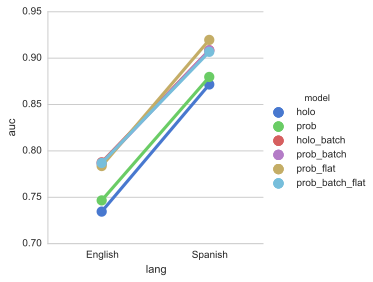

In [40]:
# Plot area under curve for all languages.
seaborn.factorplot('lang', 'auc', hue='model', data=roc_df, kind='point')
plt.savefig('all_roc.pdf')

# BLEU

In [18]:
bleu_df = pd.read_pickle('pickles/bleu')

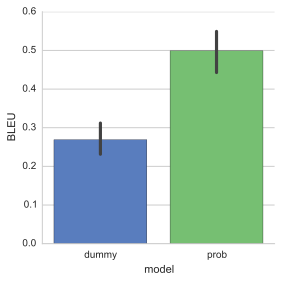

In [19]:
seaborn.factorplot(x='model', y='BLEU', data=bleu_df, kind='bar',
#             order=['holo', 'compose', 'prob',  'trigram']
               )
# plt.legend().draw_frame(True)
plt.savefig('figs/bleu.pdf')

In [ ]:
# full_df = roc_df[['ROC area under curve', 'model', 'language']].rename(columns={'ROC area under curve': 'measure'}).head()

full_df = pd.concat([pd.melt(roc_df, id_vars=['model', 'language'],
                   value_vars=['ROC area under curve'], var_name='measure'), 
           pd.melt(bleu_df, id_vars=['model', 'language'],
                   value_vars=['BLEU'], var_name='measure')])
    
seaborn.factorplot('model', 'value', hue='language', col='measure', data=full_df,
                   kind='bar', col_order=['BLEU', 'ROC area under curve'],
                   order=['holo', 'prob', 'trigram', 'random'])
plt.savefig('figs/combined.pdf')